In [1]:
import numpy as np
import pandas as pd
from utils import read_data, process_time, merge_data, promo_detector
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import xgboost as xgb
from sasaki_features import add_feature_promotion

In [2]:
infos, items, orders = read_data("../main/datasets/")

process_time(orders)
items, orders = add_feature_promotion(items, orders)

In [3]:
print(items.head())
print(orders.head())

   itemID  brand  manufacturer  customerRating  category1  category2  \
0       1      0             1            4.38          1          1   
1       2      0             2            3.00          1          2   
2       3      0             3            5.00          1          3   
3       4      0             2            4.44          1          2   
4       5      0             2            2.33          1          1   

   category3  recommendedRetailPrice  modeSalesPrice  
0          1                    8.84            3.11  
1          1                   16.92            9.15  
2          1                   15.89           14.04  
3          1                   40.17           14.10  
4          1                   17.04            7.84  
                 time  transactID  itemID  order  salesPrice  days  \
0 2018-01-01 00:01:56     2278968     450      1       17.42     1   
1 2018-01-01 00:09:24     2278968     450      1       17.42     1   
2 2018-01-01 00:51:59     2

## Finding items without sales##

In [4]:
a = items.itemID.unique()
b = orders.itemID.unique()

with_sales = np.intersect1d(a,b)
no_sales = np.setdiff1d(a,b)

print(f'total: {len(a)}')
print(f'with_sales: {len(with_sales)}')
print(f'no_sales: {len(no_sales)}')

total: 10463
with_sales: 9840
no_sales: 623


        sum  count
itemID            
1       693    578
2         5      5
3       331    289
4       198    181
5       180    162
...     ...    ...
10450   156    145
10459     1      1
10460     1      1
10462     1      1
10463     1      1

[9808 rows x 2 columns]


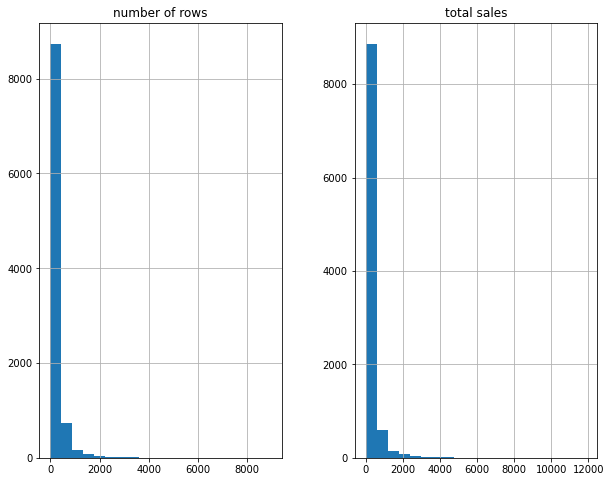

In [13]:
#printing histogram and quantiles of item sales

aux= orders.groupby(['itemID']).order.agg(['sum','count'])
print(aux)
aux = aux.reset_index()
aux = aux.rename(columns={'sum' : 'total sales','count' : 'number of rows'})

hist = aux[['total sales','number of rows']].hist(bins=20)

In [17]:
aux[['total sales','number of rows']].quantile([0.5,0.75 ,0.9, 0.95])

,total sales,number of rows
0.50,134.00,123.0
0.75,305.00,262.0
0.90,573.00,472.0
0.95,990.65,717.3


In [7]:
#removing rows with itemID without sales from
boolean = [np.isin(idd,with_sales) for idd in items.itemID]
items= items[boolean] 

## Agregating by week##  

In [8]:
orders["week_backward"] = np.ceil(orders["days_backwards"] / 7).astype(int)

#removing the first week, it has 5 days only
orders = orders[orders["week_backward"]!=26]

weeks_database = orders['week_backward'].unique()
print(f'total weeks:{len(weeks_database) }')

total weeks:25


In [9]:
orders_w = orders.groupby(['itemID','salesPrice','week_backward']).agg({'order' : ['sum'], 
                                                               'group_backwards' : ['mean'],
                                                               'modeSalesPrice' : ['mean'], 
                                                               'difModa' : ['mean']})
orders_w = orders_w.reset_index()
orders_w.columns = ['itemID','salesPrice','week_backward','order','group_backwards','modeSalesPrice','difModa']
print(orders_w)

       itemID  salesPrice  week_backward  order  group_backwards  \
0           1        3.11              6     31                3   
1           1        3.11              7      2                4   
2           1        3.11              8      1                4   
3           1        3.11              9      1                5   
4           1        3.11             10    298                5   
...       ...         ...            ...    ...              ...   
62445   10450       55.65              3    122                2   
62446   10459       14.71              8      1                4   
62447   10460      325.67             11      1                6   
62448   10462      304.30             10      1                5   
62449   10463      282.16              6      1                3   

       modeSalesPrice  difModa  
0                3.11      0.0  
1                3.11      0.0  
2                3.11      0.0  
3                3.11      0.0  
4                3

## Adding itemID with zero salues by week##

In [10]:
new_rows = []
for idd in orders_w['itemID'].unique():
    orders_id = orders_w[orders_w.itemID == idd]
    example = orders_id.iloc[0]
    
    #finding weeks without itemID sales
    weeks_id = orders_id['week_backward'].unique()
    weeks_without_id = np.setdiff1d(weeks_database , weeks_id)
    
    #creating new row
    for w in weeks_without_id:
        new_rows.append({'itemID':idd, 
                         'salesPrice':example['modeSalesPrice'], 
                         'week_backward':w, 
                         'order':0,
                         'group_backwards':example['group_backwards'], 
                         'modeSalesPrice':example['modeSalesPrice'], 
                         'difModa':example['difModa']
                        })

orders_w = orders_w.append(new_rows) 

OBS: the weeks will have diferent number of rows, because some item are sell with more than one price

In [11]:
print(len(orders_w[orders_w.week_backward == 5]))
print(len(orders_w[orders_w.week_backward == 3]))

10405
10343


In [12]:
print(orders_w[orders_w.week_backward == 5].itemID.nunique())
print(orders_w[orders_w.week_backward == 3].itemID.nunique())

9808
9808
